In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import pickle
import copy

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.linewidth'] = 1

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/2n")
dir = os.path.join(pickledir, "images_2n_wc_static_nodelay")

print(dir)

def get_period(timeseries, dt):
    peaks = scipy.signal.find_peaks(timeseries, prominence=0.001)[0]
    periods = []
    for i in range(2, len(peaks)-1):
        periods.append( (peaks[i] - peaks[i-1]) * dt)
    return np.mean(periods)

/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/2n/images_2n_wc_static_nodelay


In [4]:
p_names = ["D-exp", "D-osc"]
coords = [[1., 1.5], [1.5, 0.9]]

coupling = 1.8
cmat = np.array( [[0., 1.], [1., 0.]] )
N = cmat.shape[0]

D-exp
D-osc


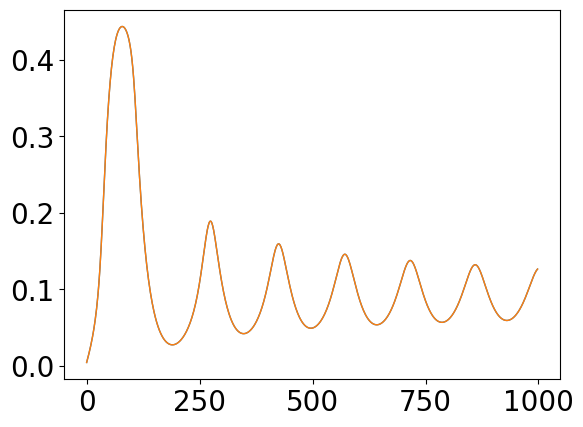

14.068888888888889 14.068888888888889


In [29]:
w2_array = np.array([1e-6,1e-5, 1e-4])
period_mult_array = np.arange(0.4, 2.1, 0.2)
period_num_array = np.arange(4, 17, 4)

if True:
    data = dict()

    for i in range(len(p_names)):
        p = p_names[i]
        data[p] = dict()
        data[p]["coordinates"] = coords[i]
        
        data[p]["control"] = [[[None for x0 in range(len(w2_array))] for x1 in range(len(period_mult_array))] for x2 in range(len(period_num_array))]
        data[p]["state"] = [[[None for x0 in range(len(w2_array))] for x1 in range(len(period_mult_array))] for x2 in range(len(period_num_array))]
        data[p]["cost"] = np.zeros(( len(period_num_array), len(period_mult_array), len(w2_array) ))
        data[p]["init_state"] = None

duration = 2000.
dt = 0.1

test_input_plus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_plus[:,:500] = 5.

test_input_minus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_minus[:,:500] = -5.

for pi in range(len(p_names)):

    print(p_names[pi])

    model = WCModel(Cmat=cmat, Dmat=0.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p_names[pi]]["coordinates"][0]
    model.params.inh_ext_baseline = data[p_names[pi]]["coordinates"][1]
    model.params["exc_ext"] = test_input_minus

    model.params.K_gl = coupling
    model.run()
    nmaxdelay = model.getMaxDelay()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p_names[pi]]["init_state"] = [einit, iinit]

    if "osc" in p_names[pi]:
        plt.plot(model.exc[0,501:1500])
        plt.plot(model.exc[1,501:1500])
        plt.show()

        per0 = get_period(-model.exc[0,601:], dt)
        per1 = get_period(-model.exc[1,601:], dt)
        data[p_names[pi]]["target_period"] = np.mean([per0, per1])
        data["D-exp"]["target_period"] = np.mean([per0, per1])

        print(per0, per1)        

In [8]:
controlmat = np.ones((N,2))

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

it = 50
maxstr = 5

pr = np.arange(0,1001,20)
testd = 1000.

zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

In [132]:
it = 100

for pi in range(len(p_names)):
    p = p_names[pi]

    print("Point ", p)

    #if pi not in [1]: continue

    for mi, mult in enumerate(period_mult_array):
        target_period = data[p]["target_period"] * mult

        # done: 0,1,3,4
        #if mi not in [0,1,2,3,4,5]: continue
        if mi not in [6]: continue

        for pi, pernum in enumerate(period_num_array):
            print("target period, number periods = ", target_period, pernum)

            model = WCModel(Cmat=cmat, Dmat=0.*cmat)
            
            model.params["exc_ext_baseline"] =  data[p]["coordinates"][0]
            model.params["inh_ext_baseline"] =  data[p]["coordinates"][1]
            model.params.K_gl = coupling
                
            model.params.duration = np.ceil(target_period*pernum)
            print("duration = ", model.params.duration)

            zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
            zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
            zero_control = np.vstack( ([zero_input]*N))
            zero_control = np.vstack( ([zero_input]*N))
            model.params["exc_ext"] = zero_control[:,0,:]
            model.params["inh_ext"] = zero_control[:,1,:]

            model.params["exc_init"] = data[p]["init_state"][0]
            model.params["inh_init"] = data[p]["init_state"][1]

            model.run()

            for wi, w2 in enumerate(w2_array):

                print("w2 = ",w2)

                #if wi not in [2]: continue
                #if pi not in [2,3]: continue

                #if data[p]["cost"][pi, mi, wi] < - 1e-4:
                #    continue

                for factor in [1]:
                #for factor in np.random.rand(2):

                    model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(0,None), control_interval=(0, None), 
                                                cost_matrix=costmat, control_matrix=controlmat, )
                    model_controlled.weights["w_p"] = 0.
                    model_controlled.weights["w_2"] = w2
                    model_controlled.weights["w_f_sync"] = 1. 
                    model_controlled.maximum_control_strength = maxstr

                    if True:
                        if type(data[p]["control"][pi][mi][wi]) != type(None):
                            model_controlled.control = data[p]["control"][pi][mi][wi].copy()
                            model_controlled.update_input()
                        else:
                            model_controlled.control +=1e-3
                            model_controlled.update_input()

                    #model_controlled.control +=1e-3
                    #model_controlled.update_input()

                    #model_controlled.grad_method = 1
                    model_controlled.channelwise_optimization = True

                    for l in range(4):
                        for k in np.arange(-8., 10., 2.):
                            model_controlled.zero_step_encountered = False
                            model_controlled.step = 10**(k)
                            model_controlled.optimize(it)

                    data[p]["control"][pi][mi][wi] = model_controlled.control.copy()
                    data[p]["state"][pi][mi][wi] = model_controlled.get_xs()
                    data[p]["cost"][pi, mi, wi] = model_controlled.cost_history[-1]

        with open(os.path.join(pickledir, '2n_wc_static_nodelay.pickle'), 'wb') as f:
            pickle.dump(data, f)

Point  D-exp
target period, number periods =  22.51022222222223 4
duration =  91.0
w2 =  1e-06
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.0792544295595371
Converged in iteration 1 with cost -0.0792544295595371
Final cost : -0.0792544295595371
Compute control for a deterministic system
Cost in iteration 0: -0.0792544295595371
Converged in iteration 3 with cost -0.07925442955953714
Final cost : -0.07925442955953714
Compute control for a deterministic system
Cost in iteration 0: -0.07925442955953714
Converged in iteration 9 with cost -0.07925442955953717
Final cost : -0.07925442955953717
Compute control for a deterministic system
Cost in iteration 0: -0.07925442955953717
Converged in iteration 2 with cost -0.07925442955953717
Final cost : -0.07925442955953717
Compute control for a deterministic system
Cost in iteration 0: -0.07925442955953717
Cost in iteration 20: -0.07925442984247426
Converged in iteration 29 with cos

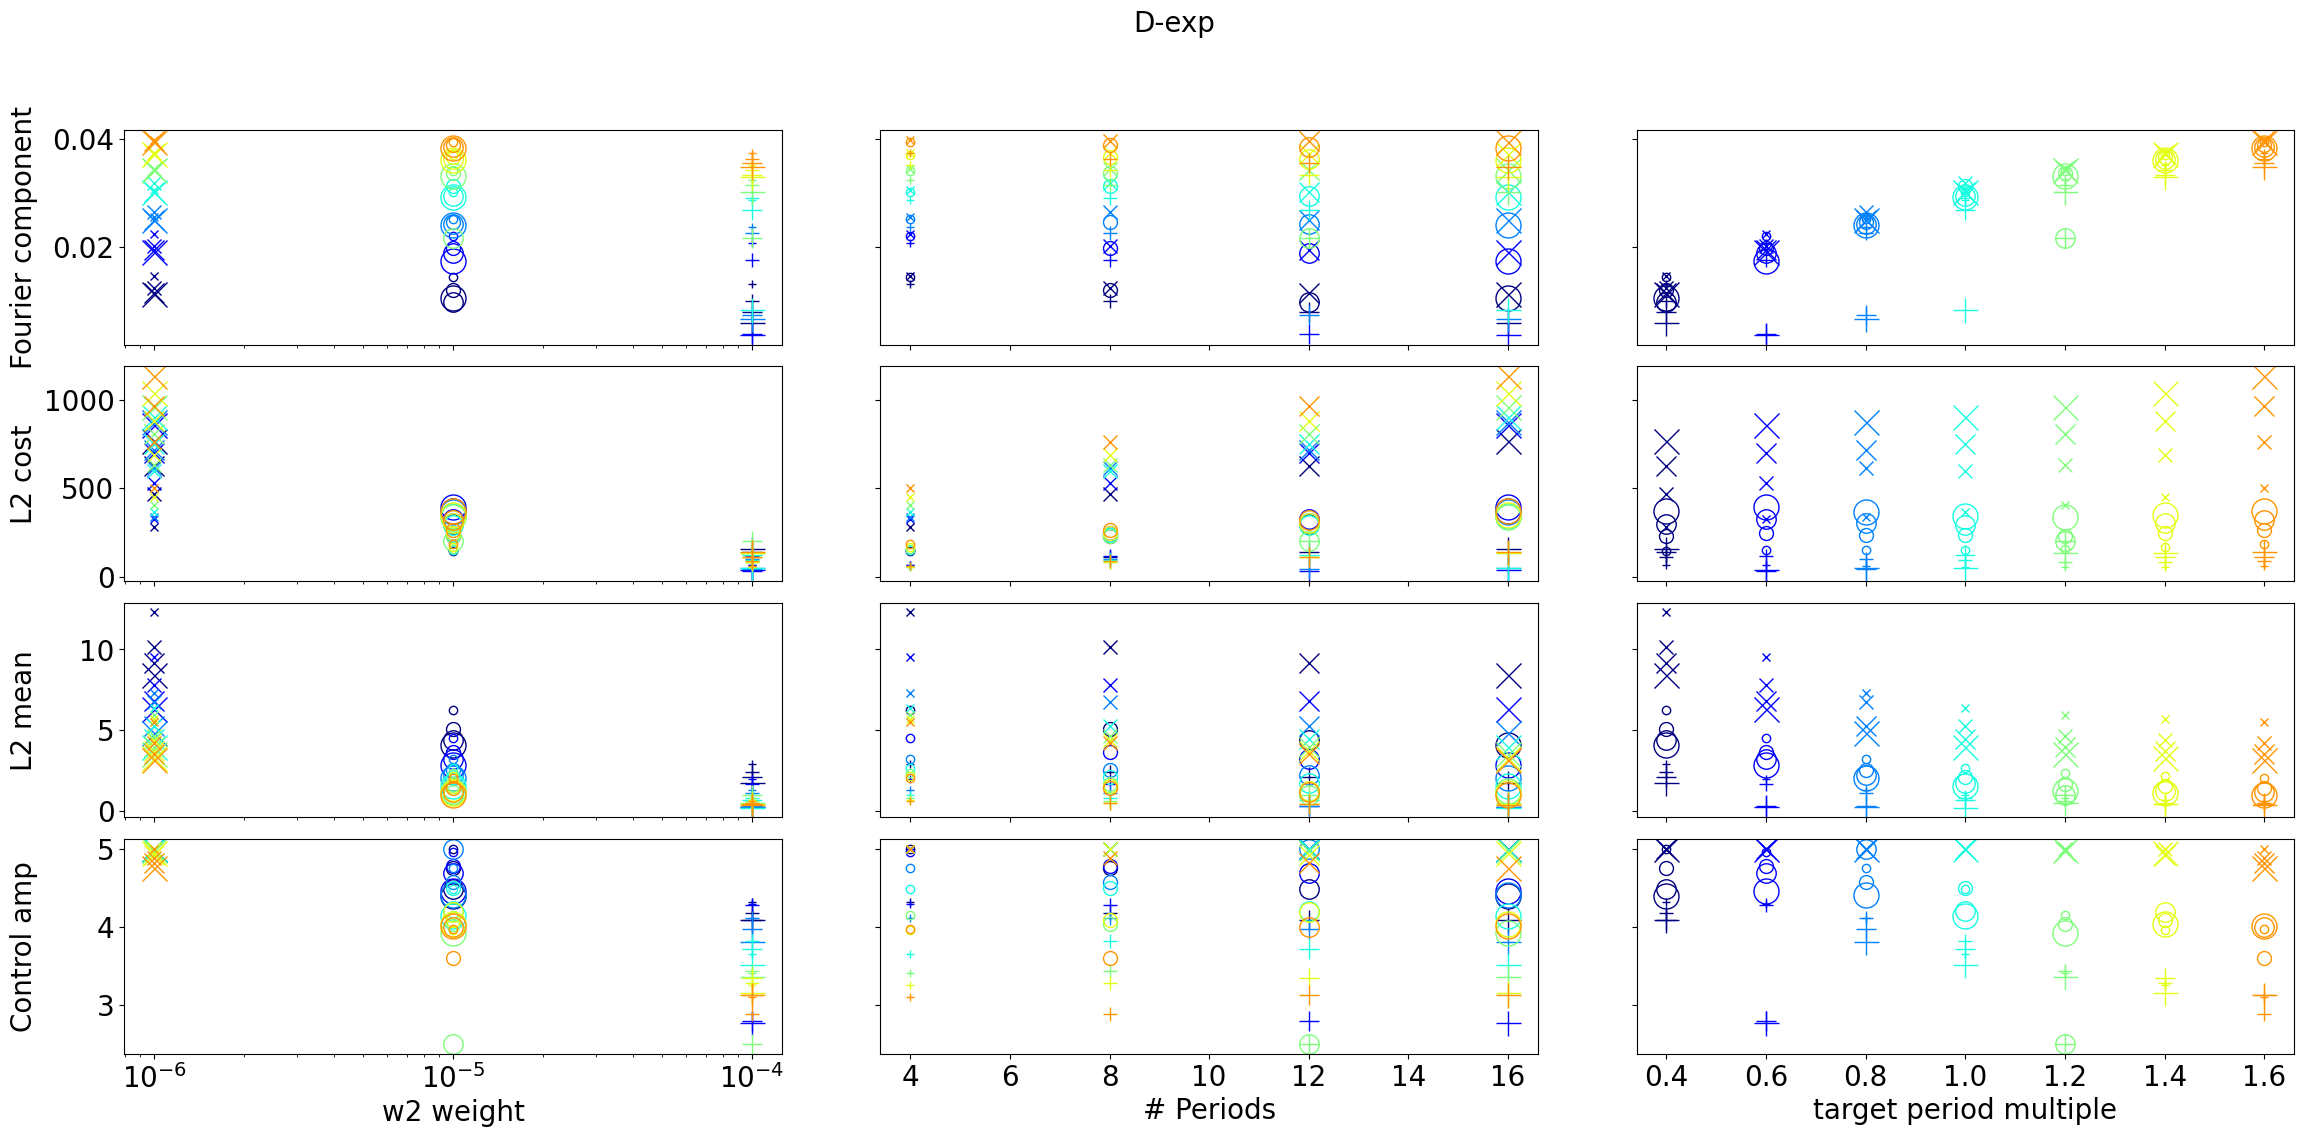

In [133]:
fig, ax = plt.subplots(4,3, figsize=(28,12), sharex="col", sharey="row")
cmap = plt.cm.get_cmap("jet")
markers = ["x", "o", "+"]

p = p_names[0]
fig.suptitle(p)

for mi, mult in enumerate(period_mult_array):
    target_period = data[p]["target_period"] * mult
    if mi > 6: continue

    for pi, pernum in enumerate(period_num_array):
        for wi, w2 in enumerate(w2_array):

            int1 = data[p]["state"][pi][mi][wi].shape[2]

            fcost = - np.sum(np.sum(cost_functions.fourier_cost(data[p]["state"][pi][mi][wi], dt, target_period, costmat, [0, int1]), axis=0), axis=0)
            ucost = np.sum(np.sum(np.sum(cost_functions.L2_cost(data[p]["control"][pi][mi][wi]), axis=0), axis=0), axis=0)*dt
            amp = np.amax(np.abs(data[p]["control"][pi][mi][wi]))

            ms =2 + pernum
            col = cmap(mi/(len(period_mult_array)-1))
            
            ax[0,0].plot(w2, fcost, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[1,0].plot(w2, ucost, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[2,0].plot(w2, ucost/(int1*dt), marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[3,0].plot(w2, amp, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )

            ax[0,1].plot(pernum, fcost, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[1,1].plot(pernum, ucost, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[2,1].plot(pernum, ucost/(int1*dt), marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[3,1].plot(pernum, amp, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )

            ax[0,2].plot(mult, fcost, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[1,2].plot(mult, ucost, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[2,2].plot(mult, ucost/(int1*dt), marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[3,2].plot(mult, amp, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )

ax[0,0].set_xscale("log")
plt.subplots_adjust(
                wspace=0.15,
                hspace=0.1)

ax[0,0].set_ylabel("Fourier component")
ax[1,0].set_ylabel("L2 cost")
ax[2,0].set_ylabel("L2 mean")
ax[3,0].set_ylabel("Control amp")

ax[3,0].set_xlabel("w2 weight")
ax[3,1].set_xlabel("# Periods")
ax[3,2].set_xlabel("target period multiple")

fig.align_ylabels([ax[:,0]])

plt.show()

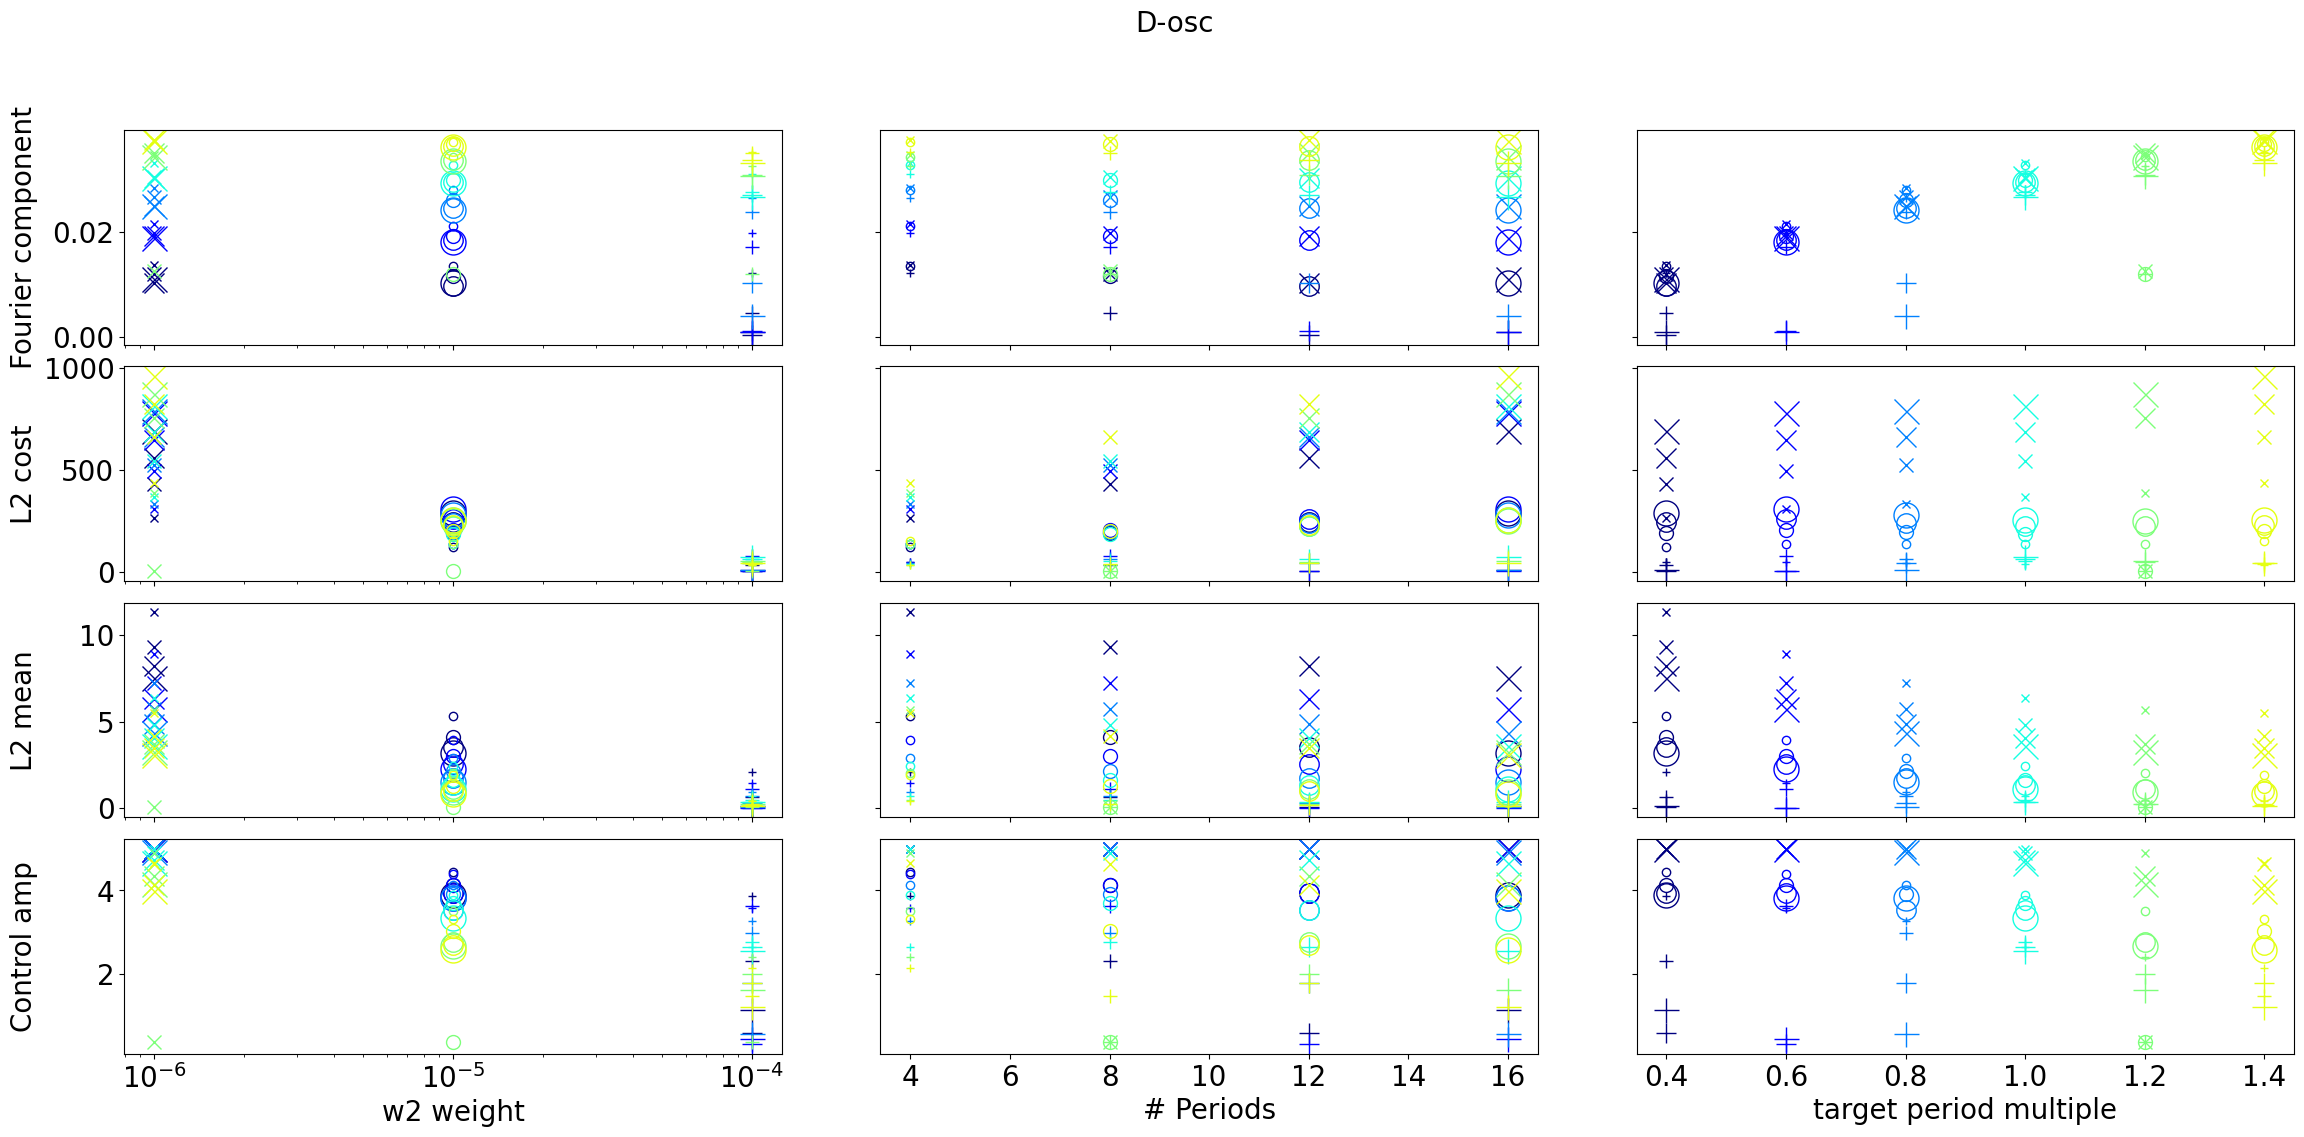

In [134]:
fig, ax = plt.subplots(4,3, figsize=(28,12), sharex="col", sharey="row")
cmap = plt.cm.get_cmap("jet")
markers = ["x", "o", "+"]

p = p_names[1]
fig.suptitle(p)

for mi, mult in enumerate(period_mult_array):
    target_period = data[p]["target_period"] * mult
    if mi > 5: continue

    for pi, pernum in enumerate(period_num_array):
        for wi, w2 in enumerate(w2_array):

            int1 = data[p]["state"][pi][mi][wi].shape[2]

            fcost = - np.sum(np.sum(cost_functions.fourier_cost(data[p]["state"][pi][mi][wi], dt, target_period, costmat, [0, int1]), axis=0), axis=0)
            ucost = np.sum(np.sum(np.sum(cost_functions.L2_cost(data[p]["control"][pi][mi][wi]), axis=0), axis=0), axis=0)*dt
            amp = np.amax(np.abs(data[p]["control"][pi][mi][wi]))

            ms =2 + pernum
            col = cmap(mi/(len(period_mult_array)-1))
            
            ax[0,0].plot(w2, fcost, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[1,0].plot(w2, ucost, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[2,0].plot(w2, ucost/(int1*dt), marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[3,0].plot(w2, amp, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )

            ax[0,1].plot(pernum, fcost, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[1,1].plot(pernum, ucost, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[2,1].plot(pernum, ucost/(int1*dt), marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[3,1].plot(pernum, amp, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )

            ax[0,2].plot(mult, fcost, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[1,2].plot(mult, ucost, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[2,2].plot(mult, ucost/(int1*dt), marker=markers[wi], color=col, markersize=ms, fillstyle='none', )
            ax[3,2].plot(mult, amp, marker=markers[wi], color=col, markersize=ms, fillstyle='none', )

ax[0,0].set_xscale("log")
plt.subplots_adjust(
                wspace=0.15,
                hspace=0.1)

ax[0,0].set_ylabel("Fourier component")
ax[1,0].set_ylabel("L2 cost")
ax[2,0].set_ylabel("L2 mean")
ax[3,0].set_ylabel("Control amp")

ax[3,0].set_xlabel("w2 weight")
ax[3,1].set_xlabel("# Periods")
ax[3,2].set_xlabel("target period multiple")

fig.align_ylabels([ax[:,0]])

plt.show()

In [25]:
with open(os.path.join(pickledir, '2n_wc_static_nodelay.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [30]:
with open(os.path.join(pickledir, '2n_wc_static_nodelay.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['D-exp', 'D-osc', 'U-exp', 'U-osc', 'Bi-exp', 'Bi-osc'])
